In [137]:
# Constants
EPOCHS:int = 10
BATCH_SIZE:int = 100
NUM_WORKERS:int = 8
MOONS: str = 'moons'
BLOBS: str = 'blobs'

In [145]:
from dataclasses import dataclass
from typing import Optional
import torch
from torch import nn
import pytorch_lightning as pl
import torchmetrics

@dataclass
class TrainingInformation:
    """ Dataclass to store training / testing Objects associated with a model"""
    model: pl.LightningModule
    train_dataloader: DataLoader
    test_dataloader: DataLoader
    ood_dataloader: DataLoader
    epochs: int
    trainer: Optional[pl.Trainer] = None

    def test_model(self, dataloader: DataLoader = None) -> None:
        if not dataloader:
            dataloader = self.test_dataloader
        trainer.test(model=self.model, dataloaders=self.test_dataloader)

    def get_ood_score(self) -> torch.Tensor:
        preds = []
        for x, y in self.ood_dataloader:
            preds.append(self.model(x))
        return torch.cat(preds)


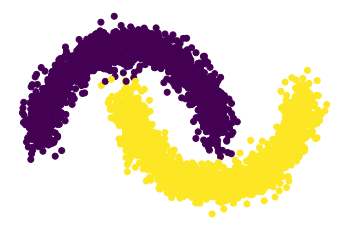

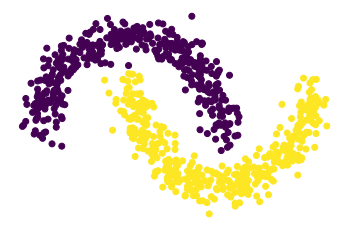

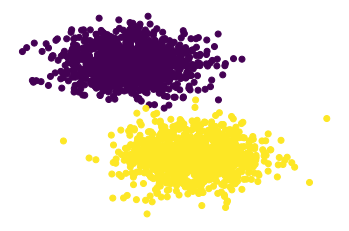

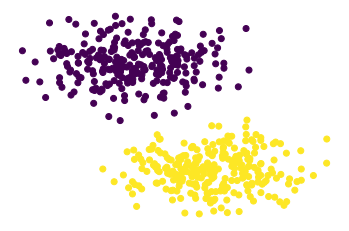

In [146]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import generate_data
import torch
from torch.utils.data import DataLoader, TensorDataset


def scatter_plot(x, labels):
    plt.scatter(x[::, 0], x[::, 1], c=labels)
    plt.axis("off")
    plt.show()

moons_Xintrain, moons_yintrain, moons_Xintest, moons_yintest, moons_Xout, moons_extent = generate_data.create_moons()
blobs_Xintrain, blobs_yintrain, blobs_Xintest, blobs_yintest, blobs_Xout, blobs_extent = generate_data.create_blobs()

# create dataloaders
def create_dataloader(x:np.ndarray, y:np.ndarray, batch_size:int, shuffle:bool, num_workers:int) -> DataLoader:
    ds = TensorDataset(torch.from_numpy(x).float(), torch.from_numpy(y).long())
    dl = DataLoader(
        dataset=ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers
    )
    return dl

moons_train_dl = create_dataloader(moons_Xintrain, moons_yintrain, BATCH_SIZE, True, NUM_WORKERS)
moons_test_dl = create_dataloader(moons_Xintest, moons_yintest, BATCH_SIZE, False, NUM_WORKERS)

blobs_train_dl = create_dataloader(blobs_Xintrain, blobs_yintrain, BATCH_SIZE, True, NUM_WORKERS)
blobs_test_dl = create_dataloader(blobs_Xintest, blobs_yintest, BATCH_SIZE, False, NUM_WORKERS)

scatter_plot(moons_Xintrain, moons_yintrain)
scatter_plot(moons_Xintest, moons_yintest)
scatter_plot(blobs_Xintrain, blobs_yintrain)
scatter_plot(blobs_Xintest, blobs_yintest)

In [147]:
class ANN(pl.LightningModule):

    def __init__(self):
        super(ANN, self).__init__()        
        self.model = torch.nn.Sequential(         
            nn.Linear(in_features=2, out_features=32),
            nn.ReLU(),                      
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=2),
            nn.Softmax(dim=0),
        )
        self.accuracy = torchmetrics.Accuracy(threshold=0.5)

    def forward(self, x):
        output = self.model(x)
        return output

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        out = self.forward(x)

        loss = nn.functional.cross_entropy(out, y)
        acc = self.accuracy(out, y)
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_accuracy", acc, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        out = self.forward(x)
        acc = self.accuracy(out, y)
        self.log("test_accuracy", acc, on_epoch=True)

    def backward(self, loss, optimizer, optimizer_idx):
        loss.backward(retain_graph=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [148]:
ann_moons = ANN()
ann_blobs = ANN()
ann_2_moons = ANN()
ann_2_blobs = ANN()

infos = {
    MOONS: TrainingInformation(ann_moons, moons_train_dl, moons_test_dl, blobs_test_dl, EPOCHS),
    f"{MOONS}_1": TrainingInformation(ann_2_moons, moons_train_dl, moons_test_dl, blobs_test_dl, EPOCHS * 2),
    BLOBS: TrainingInformation(ann_blobs, blobs_train_dl, blobs_test_dl, moons_test_dl, EPOCHS),
    f"{BLOBS}_1": TrainingInformation(ann_2_blobs, blobs_train_dl, blobs_test_dl, moons_test_dl, EPOCHS * 2),
}

In [149]:
for id, info in infos.items():
    trainer = pl.Trainer(max_epochs=info.epochs) 
    info.trainer = trainer
    print(f"fitting model: {info.model} for {id}")
    trainer.fit(model=info.model, train_dataloaders=info.train_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | model    | Sequential | 1.2 K 
1 | accuracy | Accuracy   | 0     
----------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


fitting model: ANN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
    (5): Softmax(dim=0)
  )
  (accuracy): Accuracy()
) for moons


/home/paul/workspaces/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | model    | Sequential | 1.2 K 
1 | accuracy | Accuracy   | 0     
----------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


fitting model: ANN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
    (5): Softmax(dim=0)
  )
  (accuracy): Accuracy()
) for moons_1


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | model    | Sequential | 1.2 K 
1 | accuracy | Accuracy   | 0     
----------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


fitting model: ANN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
    (5): Softmax(dim=0)
  )
  (accuracy): Accuracy()
) for blobs


/home/paul/workspaces/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | model    | Sequential | 1.2 K 
1 | accuracy | Accuracy   | 0     
----------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


fitting model: ANN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
    (5): Softmax(dim=0)
  )
  (accuracy): Accuracy()
) for blobs_1


Training: 0it [00:00, ?it/s]

In [142]:
for _, info in infos.items():
    info.test_model()

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8500000238418579
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8412500023841858
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9962546825408936
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9962546825408936
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [150]:
ood_scores = {}
for id, info in infos.items():
    ood_score, label = torch.max(info.get_ood_score(), dim=1)
    ood_scores[id] = (ood_score, label, info.ood_dataloader.dataset.tensors[0].detach())
    

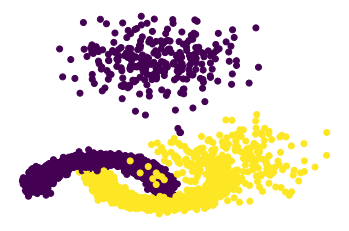

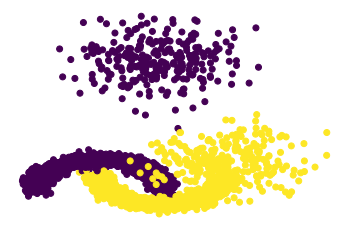

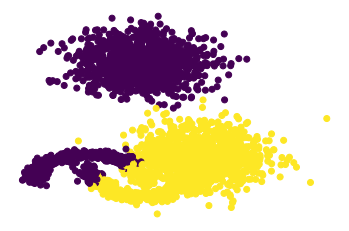

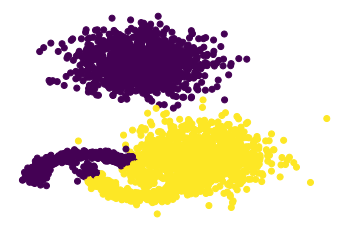

In [151]:
for id, (ood_score, label, dataset) in ood_scores.items():
    x_0, y_0 =  infos[id].train_dataloader.dataset.tensors
    x = torch.cat((x_0.detach(), dataset))
    y = torch.cat((y_0.detach(), label.detach()))
    scatter_plot(x, y)

In [157]:
auroc = torchmetrics.AUROC(pos_label=1)
aurocs = {}
for id, info in infos.items():
    x_in = info.test_dataloader.dataset.tensors[0]
    in_preds, _ = torch.max(info.model(x_in), dim=1)
    out_preds, _ = torch.max(info.get_ood_score(), dim=1)
    l_in = torch.ones_like(in_preds)
    l_out = torch.zeros_like(out_preds)
    preds = torch.cat([in_preds, out_preds])
    targets = torch.cat([l_in, l_out]).long()
    aurocs[id] = auroc(preds, targets)
    

/home/paul/workspaces/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tensor([1, 1, 1,  ..., 0, 0, 0])
tensor([1, 1, 1,  ..., 0, 0, 0])
tensor([1, 1, 1,  ..., 0, 0, 0])
tensor([1, 1, 1,  ..., 0, 0, 0])


In [158]:
print(aurocs)

{'moons': tensor(0.4742), 'moons_1': tensor(0.5907), 'blobs': tensor(0.0216), 'blobs_1': tensor(0.0291)}
